# Context-dependent PSIICOS

June 2025

Daria Kleeva 

dkleeva@gmail.com

## Import

In [1]:
import mne
import os
import sys
import importlib
sys.path.append('/home/dkleeva/Projects/dkleeva/CD-PSIICOS/src/')
if 'inv' in sys.modules:
    for mod in ['inv', 'conn', 'psiicos']:
        importlib.reload(sys.modules[mod])
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from mne.time_frequency import tfr_multitaper
from tqdm import tqdm
from fwd import prepare_fwd_2d
from conn import compute_sensor_cs, build_connectivity_matrix, plot_pairs, plot_mean_coupling_trace
from inv import scan_fast, power_map_mne, power_map_sloreta, power_map_dics, plot_power_map
from psiicos import make_psiicos_projector, apply_psiicos_projection


## Inspect the sample data

In this example we extract and visualise oscillatory activity from MEG recordings. We first load the sample dataset and segment it into epochs around the “visual/right” stimulus. To isolate induced (non-phase-locked) oscillations, we subtract the evoked response and apply time–frequency decomposition. We then visualise the resulting power map to highlight event-related spectral changes. Finally, we apply a bandpass filter in the low-beta range (16–20 Hz), crop the time window and downsample the signal to prepare it for further analysis.

In [2]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)
events = mne.find_events(raw, stim_channel="STI 014")
reject_criteria = dict(
    mag=4000e-15,
    grad=4000e-13,
    eeg=150e-6, 
    eog=250e-6,
) 
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=reject_criteria,
    preload=True,
)["visual/right"]
epochs.pick('mag')

Opening raw data file /home/dkleeva/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  e

<Epochs | 68 events (all good), -0.2 – 0.499 s (baseline -0.2 – 0 s), ~8.6 MB, data loaded,
 'visual/right': 68>

Projections have already been applied. Setting proj attribute to True.


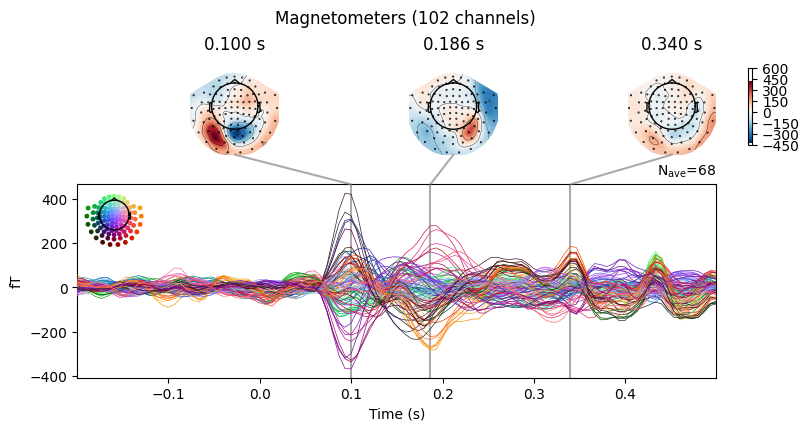

In [3]:
epochs.average().plot_joint()
plt.show()

Subtracting Evoked from Epochs
[done]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    8.7s


Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


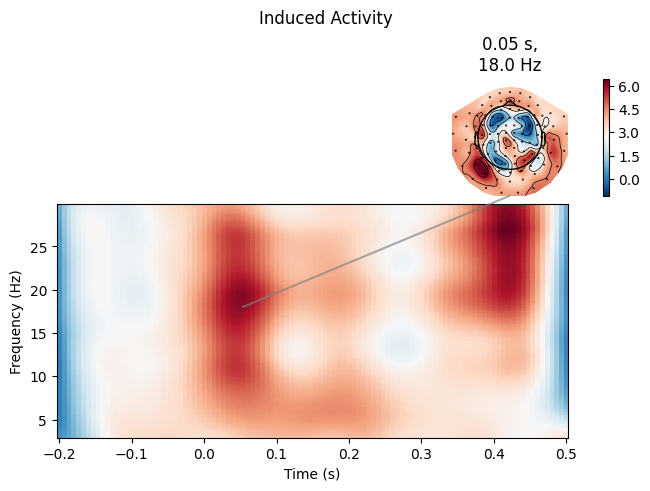

In [4]:
epochs_induced = epochs.copy().subtract_evoked()
frequencies = np.arange(3, 30, 0.2)  
n_cycles = frequencies / 3. 
power = epochs_induced.compute_tfr(
    method="morlet",
    freqs=frequencies,
    n_cycles=n_cycles,
    average=False,
    return_itc=False
)

power.average().plot_joint(timefreqs=[0.05, 18],baseline=(-0.2,0),  mode='zscore', title='Induced Activity')
plt.show()

In [5]:
epochs_induced.filter(16,20)
epochs_induced.crop(-0.2, 0.2)
epochs_induced.resample(250)

Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 125 samples (0.832 s)



/tmp/ipykernel_2291/2038509.py:1: RuntimeWarning: filter_length (125) is longer than the signal (106), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_induced.filter(16,20)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.

<Epochs | 68 events (all good), -0.2 – 0.204 s (baseline -0.2 – 0 s), ~8.4 MB, data loaded,
 'visual/right': 68>

## Prepare forward model and compute projectors

In [6]:
subjects_dir = str(sample_data_folder) + '/subjects'
subject = 'sample'
trans = str(sample_data_folder) + '/MEG/sample/sample_audvis_raw-trans.fif'
bem_sol = str(sample_data_folder) + '/subjects/sample/bem/sample-5120-5120-5120-bem-sol.fif'
src = mne.setup_source_space(subject, spacing='ico4', subjects_dir=subjects_dir) #Used low resolution for faster computations

# Load existing BEM model
bem = mne.read_bem_solution(bem_sol)

info = epochs.info 

# Compute forward solution 
fwd = mne.make_forward_solution(
    info,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    n_jobs=1
)

# Convert to free orientation 
fwd = mne.convert_forward_solution(
    fwd,
    surf_ori=True,     # orient dipoles tangentially to the surface
    force_fixed=False, # allow free orientations
    use_cps=True       # cortical patch statistics for orientation estimation
)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /home/dkleeva/mne_data/MNE-sample-data/subjects
Subject      = sample
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /home/dkleeva/mne_data/MNE-sample-data/subjects/sample/surf/lh.white...
Mapping lh sample -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/dkleeva/mne_data/MNE-sample-data/subjects/sample/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/155407 selected to source space (ico = 4)

Loading /home/dkleeva/mne_data/MNE-sample-data/subjects/sample/surf/rh.white...
Mapping rh sample -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/dkleeva/mne_data/MNE-sample-data/subjects/sample/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 2562/156866 selected t

In [7]:
G2d, G2d_raw = prepare_fwd_2d(fwd)

In [8]:
CT,_,_ = compute_sensor_cs(epochs_induced)

To construct the spatial-leakage suppression projector required for CD-PSIICOS, we first estimate the cortical power distribution from the real part of the averaged cross-spectral matrix using an inverse method (e.g., MNE). These power estimates serve as weights to emphasize the most active sources during projector construction. We then build the corresponding SL subspace using weighted auto-topographies derived. This produces a set of spatial vectors tailored to suppress leakage from the strong sources (CD-PSIICOS), which we compare to the unweighted variant (standard PSIICOS).

In [9]:
CT_avg = np.real(CT).mean(axis=1).reshape(G2d.shape[0], G2d.shape[0])

# list_of_inverses = ['MNE', 'sLORETA', 'DICS']
list_of_inverses = ['MNE']
power_maps={}
power_maps['MNE'] =  power_map_mne(G2d, CT_avg, lambd=1)
power_maps['sLORETA'] =  power_map_sloreta(G2d, CT_avg, lambd=1)
power_maps['DICS'] =  power_map_dics(G2d, CT_avg)

spatial_vecs={}

for inverse in tqdm(list_of_inverses):
    P,U = make_psiicos_projector(G2d, weights=power_maps[inverse])
    spatial_vecs[f'CD-PSIICOS_{inverse}'] = U.copy()
P,U = make_psiicos_projector(G2d, weights = None)
spatial_vecs[f'standard PSIICOS'] = U.copy()

100%|██████████| 1/1 [06:58<00:00, 418.85s/it]


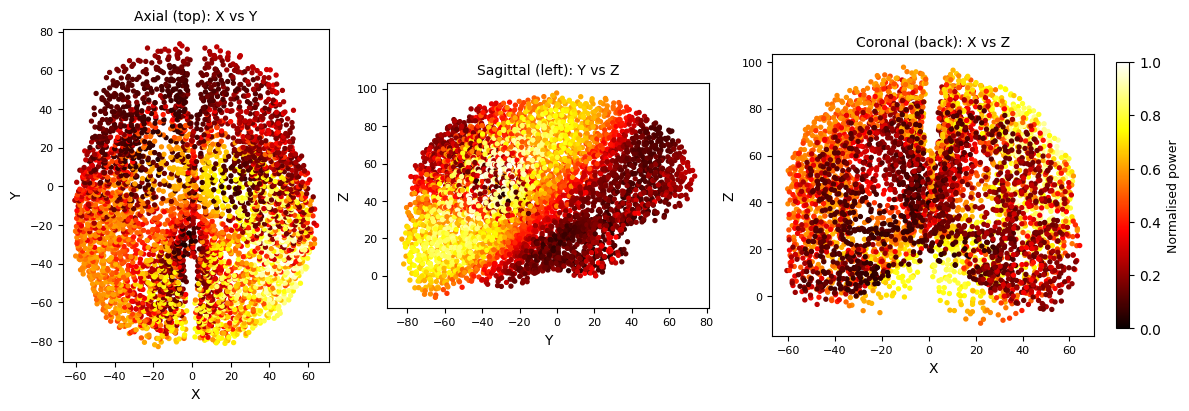

In [10]:
plot_power_map(
    fwd,
    power_map=power_maps['DICS'],
    subject="fsaverage",
    subjects_dir=subjects_dir ,
    point_size=8
)
plt.show()

## Apply PSIICOS projectors

Once the spatial-leakage subspaces have been constructed, we apply the PSIICOS or CD-PSIICOS projectors to the full cross-spectral time series. This step removes components associated with spatial leakage by projecting the data orthogonally to the leading rank singular vectors of the auto-topography subspace. The result is a cleaned cross-spectrum (CT_proj) for each condition, where spurious zero-lag correlations are attenuated, allowing reliable detection of the genuine functional coupling.

In [11]:
rank = 80
CT_proj={}
for cond in spatial_vecs.keys():
    CT_proj[cond] = apply_psiicos_projection(CT, spatial_vecs[cond], rank)

## Inverse modeling

To estimate source-space functional connectivity, we applied the scanning algorithm to each time slice of the projected cross-spectrum. This step quantifies coupling strength between all pairs of sources using the projected data, yielding a time-resolved connectivity profile. Alternatively, it is also valid to perform the faster scan on a time-averaged cross-spectrum, which offers a more compact representation of dominant network structure while sacrificing temporal resolution.

In [ ]:
C_ts = {}
for cond in tqdm(spatial_vecs.keys()):
    C_ts[cond] = []
    for t in range(CT_proj[cond].shape[1]):
        C_vec, IND = scan_fast(G2d, CT_proj[cond][:, t], part="real")
        C_ts[cond].append(C_vec)
    C_ts[cond] = np.asarray(C_ts[cond]).T  

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
conn_matrices={}
for cond in ['CD-PSIICOS_MNE']:
# for cond in spatial_vecs.keys():
    conn_matrices[cond] = build_connectivity_matrix(
        C_ts=C_ts[cond],
        pair_idx=IND,  
        times=epochs_induced.times,
        tmin=0,
        tmax=0.1,
        keep_top=0.15,
    )

## Vizualization

This step highlights a key distinction between the standard PSIICOS and its more selective variant, CD-PSIICOS. While PSIICOS effectively suppresses spatial leakage, it tends to emphasize strong local couplings, which often include false positives arising from spatial proximity to the active sources. In contrast, CD-PSIICOS incorporates a prior on source power distribution—derived from inverse solutions like MNE to reweight the projector and better target connections that cannot be explained by local activation alone. As a result, CD-PSIICOS tends to down-weight spurious local synchrony and instead reveals more plausible long-range couplings, which are often overlooked by standard PSIICOS due to their lower raw signal amplitude.

In [ ]:
cond = 'CD-PSIICOS_MNE'
plot_pairs(
    fwd,
    conn_mat=conn_matrices[cond],
    rel_thr=0.9,  
    subject="sample",
    subjects_dir=subjects_dir,
)
# view.open_in_browser()

In [ ]:
avg_trace = plot_mean_coupling_trace(
    C_ts=C_ts[cond],
    pair_idx=IND,
    conn_mat=conn_matrices[cond],       # thresholded matrix from build_connectivity_matrix
    times=epochs_induced.times,
    tmin=-0.2,
    tmax=0.2,
    return_ts=True,
)

In [ ]:
cond = 'standard PSIICOS'
plot_pairs(
    fwd,
    conn_mat=conn_matrices[cond],
    rel_thr=0.9,  
    subject="sample",
    subjects_dir=subjects_dir,
)
# view.open_in_browser()

In [ ]:
avg_trace = plot_mean_coupling_trace(
    C_ts=C_ts[cond],
    pair_idx=IND,
    conn_mat=conn_matrices[cond],       # thresholded matrix from build_connectivity_matrix
    times=epochs_induced.times,
    tmin=-0.2,
    tmax=0.2,
    return_ts=True,
)